In [153]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from pandas.plotting import scatter_matrix

from utility_funcs import PCA_transform
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.image as mpimg

%matplotlib inline

## Load in the data

In [43]:
# patient suffixes for file names
mayo_suffs = ['001','002','003','004','005','006','007','008']
sans_suffs = ['01','02','03','04','05','06','07','08','09','10']
data_bypat = {} # holder for data seperated by patient

# loading the data from the pickle files
for s, suff in enumerate(sans_suffs):
    filename = 'feature_data/sansum-%s.p' % suff
    data_bypat['s%s' % (s+1)] = pickle.load(open(filename,'rb'))
    data_bypat['s%s' % (s+1)] = data_bypat['s%s' % (s+1)].fillna(data_bypat['s%s' % (s+1)].mean())
    
for m, suff in enumerate(mayo_suffs):
    filename = 'feature_data/mayo-%s.p' % suff
    data_bypat['m%s' % (m+1)] = pickle.load(open(filename,'rb'))
    data_bypat['m%s' % (m+1)] = data_bypat['m%s' % (m+1)].fillna(data_bypat['m%s' % (m+1)].mean())

In [45]:
data_bypat['m4'].columns # ensure data was properly imported

Index(['BG0', 'BG_PH', 'BGday_var', 'dBG30', 'dBG60', 'deda30', 'deda60',
       'dtemp30', 'dtemp60', 'eda0', 'edaday_var', 'full_time', 'hr0', 'step0',
       't0', 'temp0', 'tempday_var', 'step0mean_1hr', 'step0mean_2hr',
       'step0mean_3hr', 'step0mean_4hr', 'step0mean_5hr', 'hr0adj_curr',
       'hr0adj_mean_1hr', 'hr0adj_mean_2hr', 'hr0adj_mean_3hr',
       'hr0adj_mean_4hr', 'hr0adj_mean_5hr'],
      dtype='object')

No need to standardize with random forests 

In [4]:
# Generate 9 folds with random pairs of patients for cross validation
def get_folds(data):
    keynames = list(data.keys()) # get the key names that represent individual patients
    random.shuffle(keynames) # shuffle them into a random order
    folds = np.reshape(keynames, [9,2]) # pair them off into 9 folds
    return folds

In [52]:
### takes in the by patient data and the folds by which to seperate, outputs training features/labels and testing features/labels for the current fold being tested 
def get_train_test(data,folds,current_fold):
    ## get the test data
    
    # extract patients in current fold for testing
    test_data1 = data[folds[current_fold,0]]
    test_data2 = data[folds[current_fold,1]]
    # combine into one testing df
    test_data = pd.concat([test_data1,test_data2],ignore_index=True)
    # split into predictors and labels
    test_y = test_data['BG_PH']
    test_x = test_data.drop(columns=['BG_PH'])
    
    
    ## extract patients not in current fold for training
    
    # drop the testing fold and flatten the patient array for iteration
    train_pats = np.delete(folds,current_fold,axis=0).flatten()
    train_data = pd.DataFrame() # holder df for training data
    # combine into one training df
    for pat in train_pats:
        train_data = pd.concat([train_data,data[pat]], ignore_index=True)
    train_y = train_data['BG_PH']
    train_x = train_data.drop(columns=['BG_PH'])
        
    return test_y, test_x, train_y, train_x

In [53]:
def get_RMSE(actual,predicted):
    return np.sqrt(np.mean((actual-predicted)**2))

In [54]:
def cross_validate(model, data, folds):
    rmses = [] # holder
    train_rmses = []
    # for each fold, fit and score model
    for fold in range(len(folds)):
        test_y, test_x, train_y, train_x = get_train_test(data_bypat,folds,fold) # split data for given fold
        model.fit(train_x,train_y) # fit model on training set for fold
        y_preds = model.predict(test_x) # predict on validation fold
        rmses.append(get_RMSE(test_y,y_preds)) # append rmse to holder
        train_rmses.append(get_RMSE(train_y,model.predict(train_x)))
        
    # get mean and standard deviation
    mean_rmse = np.mean(rmses)
    std_rmse = np.std(rmses)
    mean_train_rmse = np.mean(train_rmses)
    std_train_rmse = np.std(train_rmses)
    
    return mean_rmse, std_rmse, mean_train_rmse, std_train_rmse

In [55]:
folds = get_folds(data_bypat)
test_y, test_x, train_y, train_x = get_train_test(data_bypat,folds,1)
len(folds)

9

In [56]:
feature_cols = set(train_x.columns)-set(["full_time"])
train_x_time = train_x.copy()
train_x = train_x[feature_cols]
test_x_time = test_x.copy()
test_x = test_x[feature_cols]

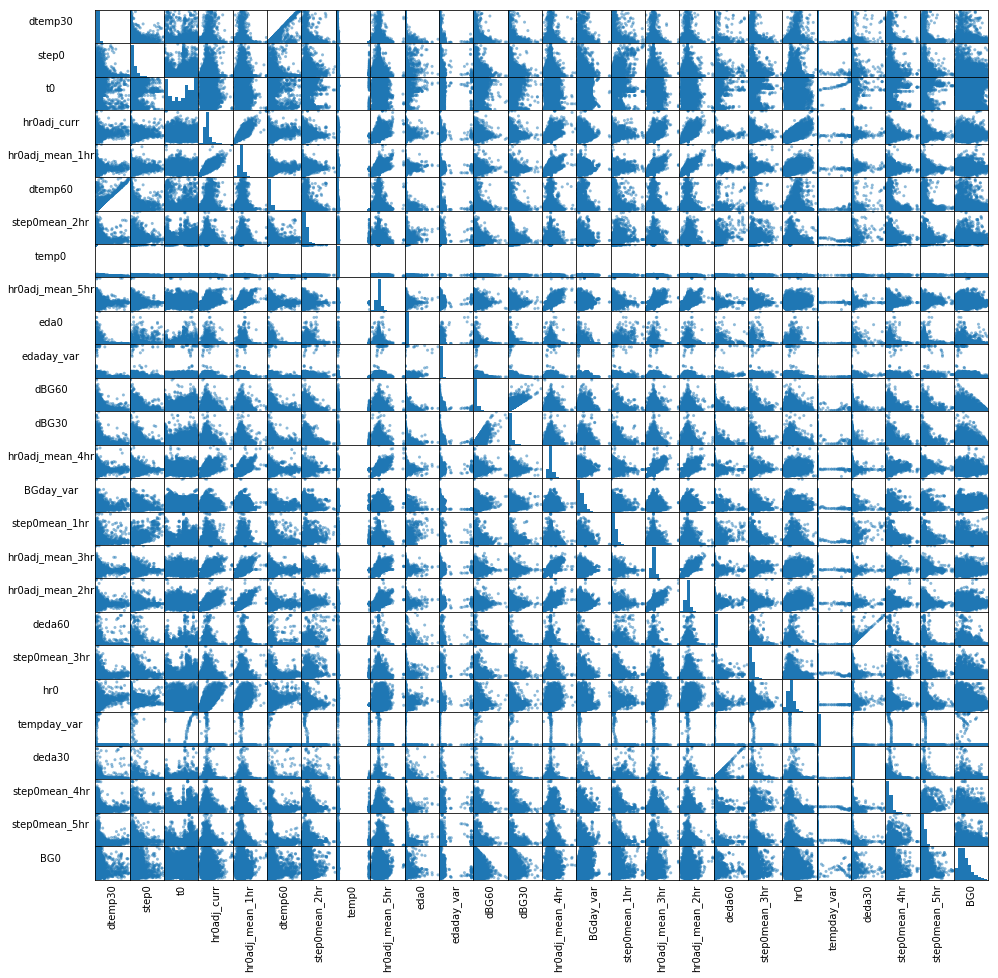

In [31]:
### Generate the scatter matrix
# copy x df | reappend y vals
plot_df = train_x.copy()
#plot_df['y'] = train_y

# subsample for runtime
subplot_df = plot_df.sample(frac=.25, replace=False)
corr_plot = scatter_matrix(subplot_df, figsize=[16,16])

#Change label rotation
[s.xaxis.label.set_rotation(90) for s in corr_plot.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in corr_plot.reshape(-1)]

#May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-1.3,0.5) for s in corr_plot.reshape(-1)]

#Hide all ticks
[s.set_xticks(()) for s in corr_plot.reshape(-1)]
[s.set_yticks(()) for s in corr_plot.reshape(-1)];

In [9]:
def scale_data(xtrain,xtest):
    scaler = StandardScaler() # generate scaler
    xtrain.loc[:,:] = scaler.fit_transform(xtrain) # fit and transform on training
    xtest.loc[:,:] = scaler.transform(xtest) # naively transform test data without fitting to it
    return xtrain, xtest, scaler

In [10]:
def PCA_transform_(train_x, test_x):
    train_x, test_x, __ = scale_data(train_x, test_x)
    pca = PCA() # full PCA with no automatic truncation
    train_pca = pca.fit_transform(train_x) # fit the pca and transform the training values
    test_pca = pca.transform(test_x) # transform the test data without looking at it fr adjusting pca
    return train_pca, test_pca, pca.explained_variance_ratio_, train_x

0.17648403519494776
0.128656815104269
0.07878872820196091
0.07425692482919861
0.06911687494261631
0.05884813073061407
0.050916045387685134
0.04512312396324145
0.04034174909267659
0.0369981599317402
0.0330341681410322
0.029689460321921313
0.029377689650134178
0.024995734986455003
0.023745894950485902
0.01936849758377636
0.014710376170467233
0.013252515877531167
0.009961640185276984
0.009473645009718482
0.007484588599509279
0.006651558600568315
0.0059937832540323
0.005341897840159347
0.004348784748575101
0.003039176701406887


Text(0.5, 1.0, 'PCA for Dimensionality Reduction')

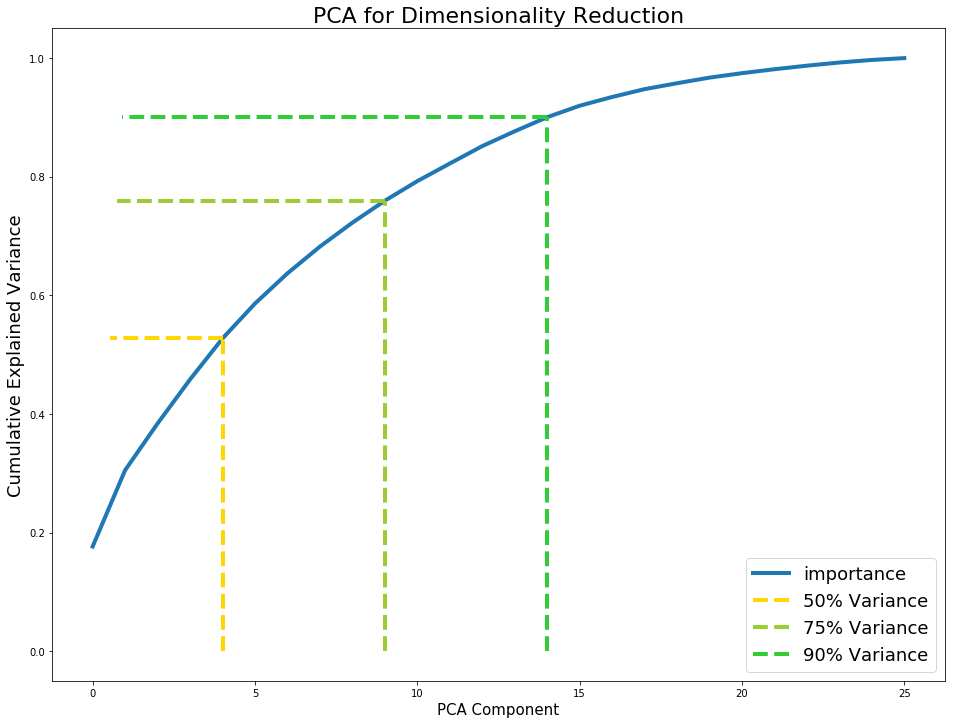

In [18]:
x_pca_train,x_pca_test, importances, x_hmm= PCA_transform_(train_x,test_x)
cum_importance = [0]
for imp in importances:
    print(imp)
    cum_importance.append(cum_importance[-1]+imp)
cum_importance = cum_importance[1:]
plt.figure(figsize=[16,12])
plt.plot(cum_importance, lw=4)
plt.plot([4,4],[0,cum_importance[4]],'--', color='gold', lw=4)
plt.plot([9,9],[0,cum_importance[9]],'--', color='yellowgreen', lw=4)
plt.plot([14,14],[0,cum_importance[14]],'--', color='limegreen', lw=4)
plt.plot([4,cum_importance[4]],[cum_importance[4],cum_importance[4]],'--', color='gold', lw=4)
plt.plot([9,cum_importance[9]],[cum_importance[9],cum_importance[9]],'--', color='yellowgreen', lw=4)
plt.plot([14,cum_importance[14]],[cum_importance[14],cum_importance[14]],'--', color='limegreen', lw=4)
plt.xlabel('PCA Component', fontsize=15)
plt.ylabel('Cumulative Explained Variance', fontsize=18)
plt.legend(['importance', '50% Variance', '75% Variance', '90% Variance'], fontsize=18, loc='lower right')
plt.title('PCA for Dimensionality Reduction', fontsize=22)

In [19]:
cum_importance

[0.17648403519494776,
 0.3051408502992168,
 0.3839295785011777,
 0.4581865033303763,
 0.5273033782729926,
 0.5861515090036067,
 0.6370675543912918,
 0.6821906783545333,
 0.7225324274472099,
 0.7595305873789501,
 0.7925647555199823,
 0.8222542158419036,
 0.8516319054920378,
 0.8766276404784928,
 0.9003735354289788,
 0.9197420330127551,
 0.9344524091832224,
 0.9477049250607535,
 0.9576665652460306,
 0.967140210255749,
 0.9746247988552583,
 0.9812763574558266,
 0.987270140709859,
 0.9926120385500183,
 0.9969608232985935,
 1.0000000000000004]

In [11]:
# THINGS TO OPTIMIZE; num trees, max depth
forest = RandomForestRegressor(max_features=len(train_x.columns)//3)
forest.fit(train_x,train_y)
y_preds = forest.predict(train_x)
rmse = get_RMSE(train_y,y_preds)

C:\Users\coh275\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [36]:
tree_nums = [1, 5, 10, 50, 100] # number of trees in the forest 
depths = [1, 5, 10, 15, 20] # how deep to make each tree

In [37]:
cvmeans = np.zeros([len(tree_nums),len(depths)]) # holder for mean cv scores at each depth and number combo
cvstds = np.zeros([len(tree_nums),len(depths)]) # holder for standard deviations of cv scores at each depth and number combo

In [38]:
folds = get_folds(data_bypat) # get folds for cross validation

for t, tree_num in enumerate(tree_nums):
    for d, depth in enumerate(depths):
        print('[',t,d,']')
        # make forest
        forest = RandomForestRegressor(n_estimators=tree_num, max_depth=depth, max_features=len(train_x.columns)//3)
        # cross validate and get rmse and its standard deviation
        mean_rmse, std_rmse = cross_validate(forest, data_bypat, folds)
        #store results
        cvmeans[t,d] = mean_rmse
        cvstds[t,d] = std_rmse
        

[ 0 0 ]
[ 0 1 ]
[ 0 2 ]
[ 0 3 ]
[ 0 4 ]
[ 1 0 ]
[ 1 1 ]
[ 1 2 ]
[ 1 3 ]
[ 1 4 ]
[ 2 0 ]
[ 2 1 ]
[ 2 2 ]
[ 2 3 ]
[ 2 4 ]
[ 3 0 ]
[ 3 1 ]
[ 3 2 ]
[ 3 3 ]
[ 3 4 ]
[ 4 0 ]
[ 4 1 ]
[ 4 2 ]
[ 4 3 ]
[ 4 4 ]


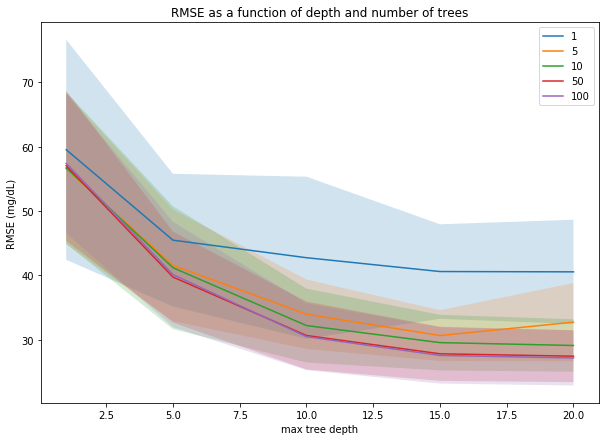

In [39]:
plt.figure(figsize=[10,7])
for tr in range(len(tree_nums)):
    plt.plot(depths, cvmeans[tr,:])
    plt.fill_between(depths, cvmeans[tr,:]-cvstds[tr,:], cvmeans[tr,:]+cvstds[tr,:], alpha=.2)

plt.title('RMSE as a function of depth and number of trees')
plt.xlabel('max tree depth')
plt.ylabel('RMSE (mg/dL)')
plt.legend(tree_nums)

### determining effects of different feature sets (PCA, simplified, full)

In [20]:
# for determining effects of different feature sets (PCA, simplified, full)
folds = get_folds(data_bypat) # get folds for cross validation


cvmeans_pca = {}
cvstds_pca = {}
trmeans_pca = {}
trstds_pca = {}

In [23]:

# make forest
forest = RandomForestRegressor(n_estimators=50, max_depth=15, max_features=len(train_x.columns)//3)
# cross validate and get rmse and its standard deviation
mean_rmse, std_rmse, mean_rmse_tr, std_rmse_tr = cross_validate(forest, data_bypat, folds)
#store results
cvmeans_pca['full'] = mean_rmse
cvstds_pca['full'] = std_rmse
trmeans_pca['full'] = mean_rmse_tr
trstds_pca['full'] = std_rmse_tr

In [24]:
# loading the data from the pickle files
for s, suff in enumerate(sans_suffs):
    filename = 'feature_data/sansum-%s.p' % suff
    data_bypat['s%s' % (s+1)] = pickle.load(open(filename,'rb'))
    data_bypat['s%s' % (s+1)] = data_bypat['s%s' % (s+1)].fillna(data_bypat['s%s' % (s+1)].mean())
    data_bypat['s%s' % (s+1)] = data_bypat['s%s' % (s+1)].loc[:,['BG0', 'BG_PH', 'BGday_var', 'dBG30', 'dBG60','eda0','hr0','step0','t0','temp0']]
    
for m, suff in enumerate(mayo_suffs):
    filename = 'feature_data/mayo-%s.p' % suff
    data_bypat['m%s' % (m+1)] = pickle.load(open(filename,'rb'))
    data_bypat['m%s' % (m+1)] = data_bypat['m%s' % (m+1)].fillna(data_bypat['m%s' % (m+1)].mean())
    data_bypat['m%s' % (m+1)] = data_bypat['m%s' % (m+1)].loc[:,['BG0', 'BG_PH', 'BGday_var', 'dBG30', 'dBG60','eda0','hr0','step0','t0','temp0']]

In [25]:
# make forest
forest = RandomForestRegressor(n_estimators=50, max_depth=15, max_features=len(['BG0', 'BG_PH', 'BGday_var', 'dBG30', 'dBG60','eda0','hr0','step0','t0','temp0'])//3)
# cross validate and get rmse and its standard deviation
mean_rmse, std_rmse, mean_rmse_tr, std_rmse_tr = cross_validate(forest, data_bypat, folds)
#store results
cvmeans_pca['initial'] = mean_rmse
cvstds_pca['initial'] = std_rmse
trmeans_pca['initial'] = mean_rmse_tr
trstds_pca['initial'] = std_rmse_tr

KeyError: "['full_time'] not found in axis"

In [ ]:
def cross_validate_pca(model, data, folds, cutoff):
    rmses = [] # holder
    train_rmses = []
    # for each fold, fit and score model
    for fold in range(len(folds)):
        test_y, test_x, train_y, train_x = get_train_test(data_bypat,folds,fold) # split data for given fold
        train_x, test_x, __ = PCA_transform(train_x,test_x)# PCA transform
        train_x = train_x[:,:cutoff] # truncate, reduce dim
        test_x = test_x[:,:cutoff]
        model.fit(train_x,train_y) # fit model on training set for fold
        y_preds = model.predict(test_x) # predict on validation fold
        rmses.append(get_RMSE(test_y,y_preds)) # append rmse to holder
        train_rmses.append(get_RMSE(train_y,model.predict(train_x)))
        
    # get mean and standard deviation
    mean_rmse = np.mean(rmses)
    std_rmse = np.std(rmses)
    mean_train_rmse = np.mean(train_rmses)
    std_train_rmse = np.std(train_rmses)
    
    return mean_rmse, std_rmse, mean_train_rmse, std_train_rmse

In [ ]:
# loading the data from the pickle files
for s, suff in enumerate(sans_suffs):
    filename = 'feature_data/sansum-%s.p' % suff
    data_bypat['s%s' % (s+1)] = pickle.load(open(filename,'rb'))
    data_bypat['s%s' % (s+1)] = data_bypat['s%s' % (s+1)].fillna(data_bypat['s%s' % (s+1)].mean())
    
for m, suff in enumerate(mayo_suffs):
    filename = 'feature_data/mayo-%s.p' % suff
    data_bypat['m%s' % (m+1)] = pickle.load(open(filename,'rb'))
    data_bypat['m%s' % (m+1)] = data_bypat['m%s' % (m+1)].fillna(data_bypat['m%s' % (m+1)].mean())

In [ ]:
forest = RandomForestRegressor(n_estimators=50, max_depth=15, max_features=9//3)
# cross validate and get rmse and its standard deviation
mean_rmse, std_rmse, mean_rmse_tr, std_rmse_tr = cross_validate_pca(forest, data_bypat, folds, 9)
#store results
cvmeans_pca['pca_90'] = mean_rmse
cvstds_pca['pca_90'] = std_rmse
trmeans_pca['pca_90'] = mean_rmse_tr
trstds_pca['pca_90'] = std_rmse_tr

In [ ]:
forest = RandomForestRegressor(n_estimators=50, max_depth=15, max_features=6//3)
# cross validate and get rmse and its standard deviation
mean_rmse, std_rmse, mean_rmse_tr, std_rmse_tr = cross_validate_pca(forest, data_bypat, folds, 6)
#store results
cvmeans_pca['pca_75'] = mean_rmse
cvstds_pca['pca_75'] = std_rmse
trmeans_pca['pca_75'] = mean_rmse_tr
trstds_pca['pca_75'] = std_rmse_tr

In [ ]:
forest = RandomForestRegressor(n_estimators=50, max_depth=15, max_features=3//3)
# cross validate and get rmse and its standard deviation
mean_rmse, std_rmse, mean_rmse_tr, std_rmse_tr = cross_validate_pca(forest, data_bypat, folds, 3)
#store results
cvmeans_pca['pca_50'] = mean_rmse
cvstds_pca['pca_50'] = std_rmse
trmeans_pca['pca_50'] = mean_rmse_tr
trstds_pca['pca_50'] = std_rmse_tr

In [ ]:
print(cvmeans_pca)
print(trmeans_pca)

In [175]:
del cvmeans_pca['initial']
del cvstds_pca['initial']
del trmeans_pca['initial']
del trstds_pca['initial']

In [178]:
def convert_results(pca_dict,order):
    pca_list= []
    for i in range(len(order)):
        pca_list.append(pca_dict[order[i]])
    return pca_list

In [179]:
cvmeans_pca_list = convert_results(cvmeans_pca,['full', 'pca_90', 'pca_75', 'pca_50'])
cvstds_pca_list = convert_results(cvstds_pca,['full', 'pca_90', 'pca_75', 'pca_50'])
trmeans_pca_list = convert_results(trmeans_pca,['full', 'pca_90', 'pca_75', 'pca_50'])
trstds_pca_list = convert_results(trstds_pca,['full', 'pca_90', 'pca_75', 'pca_50'])

([<matplotlib.axis.YTick at 0x1ba9b430c18>,
 <a list of 4 Text yticklabel objects>)

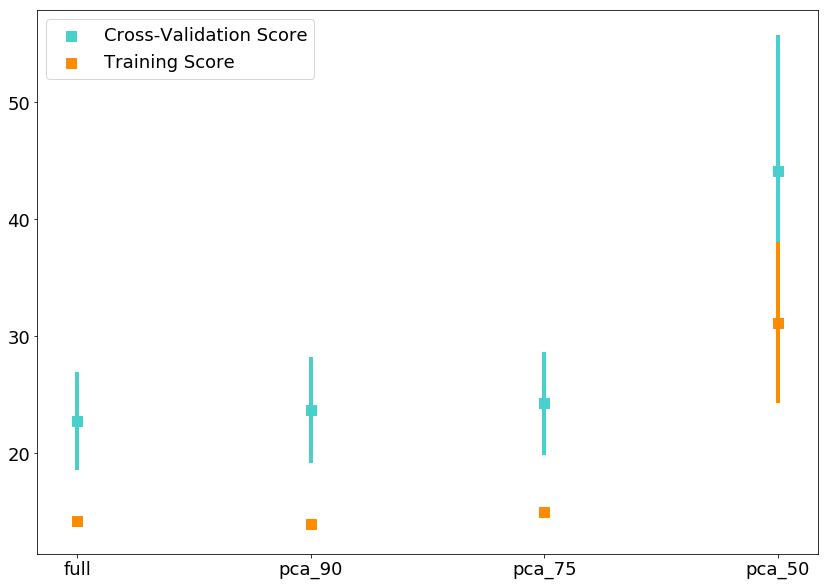

In [201]:
xvals_p = [1,2,3,4]
plt.figure(figsize=[14,10])
plt.scatter(xvals_p, cvmeans_pca_list , marker='s', color='mediumturquoise', s=100)
plt.errorbar(xvals_p, cvmeans_pca_list, cvstds_pca_list, color='mediumturquoise', fmt='none', elinewidth=4)
plt.scatter(xvals_p, trmeans_pca_list , marker='s', color='darkorange', s=100)
plt.errorbar(xvals_p, trmeans_pca_list, trstds_pca_list, color='darkorange', fmt='none', elinewidth=4)
plt.legend(["Cross-Validation Score", "Training Score"], loc="upper left", fontsize=18)
plt.xticks(xvals_p, ['full', 'pca_90', 'pca_75', 'pca_50'], fontsize=18)
plt.yticks([20,30,40,50], [20,30,40,50], fontsize=18)

In [80]:
def CEG_analysis(measured,predicted):
    
    ## determine which points fall in each region
    
    a_measured = measured.loc[(abs(measured-predicted)<=.2*measured) | ((measured<=70)&(predicted<=70))]
    a_predicted = predicted.loc[(abs(measured-predicted)<=.2*measured) | ((measured<=70)&(predicted<=70))]
    
    e_measured = measured.loc[((measured<=70)&(predicted>180)) | ((measured>180)&(predicted<=70))]
    e_predicted = predicted.loc[((measured<=70)&(predicted>180)) | ((measured>180)&(predicted<=70))]
    
    # make sure to exclude a conditions
    d_measured = measured.loc[(((predicted>70)&(predicted<=180)) & ((measured<=70)|(measured>240))) & ~(abs(measured-predicted)<=.2*measured)]
    d_predicted = predicted.loc[(((predicted>70)&(predicted<=180)) & ((measured<=70)|(measured>240))) & ~(abs(measured-predicted)<=.2*measured)]
    
    c_measured = measured.loc[(((predicted<=70)&(measured<=180))&(predicted<7/5*(measured-130))) | (((predicted>180)&(measured<predicted-110))&(measured>70))]
    c_predicted = predicted.loc[(((predicted<=70)&(measured<=180))&(predicted<7/5*(measured-130))) | (((predicted>180)&(measured<predicted-110))&(measured>70))]
    
    not_b_inds_measured = np.concatenate([a_measured.index.values,c_measured.index.values,d_measured.index.values,e_measured.index.values])
    not_b_inds_predicted = np.concatenate([a_predicted.index.values,c_predicted.index.values,d_predicted.index.values,e_predicted.index.values])
    print(np.shape(not_b_inds_measured))
    print(type(not_b_inds_measured))
    print(type(a_measured.index.values))
    print(a_measured.index.values)
    b_measured = measured.drop(index=not_b_inds_measured)
    b_predicted = predicted.drop(index=not_b_inds_predicted)

    
    ## get the percent in each region
    
    a_per = 100*len(a_measured)/len(measured)
    b_per = 100*len(b_measured)/len(measured)
    c_per = 100*len(c_measured)/len(measured)
    d_per = 100*len(d_measured)/len(measured)
    e_per = 100*len(e_measured)/len(measured)
    
    
    ## do the plotting
    
    ceg = mpimg.imread('images/CEG400_clean.jpg')
    
    plt.figure(figsize=[10,10])
    plt.imshow(ceg,extent=[0,400,0,400])
    plt.scatter(e_measured,e_predicted,c='#c90d00')
    plt.scatter(d_measured,d_predicted,c='#ff4c40')
    plt.scatter(c_measured,c_predicted,c='#ff8880')
    plt.scatter(b_measured,b_predicted,c='#93ff82')
    plt.scatter(a_measured,a_predicted,c='#28c410')
    
    
    
    
    
    plt.title('CEG Analysis', fontsize=22)
    plt.xlabel('Measured BG (mg/dL)', fontsize=22)
    plt.ylabel('Predicted BG (mg/dL)', fontsize=22)
    plt.xlim([0,400])
    plt.ylim([0,400])
    plt.legend(['E','D','C','B','A'], fontsize=22)
    
    return [a_per,b_per,c_per,d_per,e_per]

In [87]:
model = RandomForestRegressor(n_estimators=50, max_depth=15, max_features=9//3)

test_y, test_x, train_y, train_x = get_train_test(data_bypat,folds,2) # split data for given fold
train_x_, test_x_, __ = PCA_transform(train_x[feature_cols],test_x[feature_cols])# PCA transform
train_x_ = train_x_[:,:9] # truncate, reduce dim
test_x_ = test_x_[:,:9]
model.fit(train_x_,train_y) # fit model on training set for fold
y_preds = model.predict(test_x_) # predict on validation fold

C:\Users\coh275\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\coh275\Documents\Thesis programs\utility_funcs.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  xtrain.loc[:,:] = scaler.fit_transform(xtrain) # fit and transform on training
C:\Users\coh275\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#i

   BGday_var       hr0        t0  edaday_var  step0mean_1hr  step0mean_4hr  \
0  -1.296703  0.124529  0.229693   -0.204646       0.021182      -0.078355   
1  -1.285659 -0.178714  0.229693   -0.204619       0.980992      -0.078355   
2  -1.274593 -0.257345  0.229693   -0.204626       1.114103      -0.078355   
3  -1.269174 -0.205592  0.229693   -0.204560       1.060465      -0.078355   
4  -1.267218 -0.905776  0.229693   -0.204577       0.780319      -0.078355   

      dBG30  hr0adj_mean_4hr       BG0  hr0adj_mean_2hr  ...    deda30  \
0  0.500795        -0.086663 -0.045111        -0.109695  ... -0.205587   
1  0.851828        -0.086663 -0.124945        -0.109695  ... -0.205587   
2  0.781621        -0.086663 -0.172845        -0.109695  ... -0.199458   
3  0.500795        -0.086663 -0.156878        -0.109695  ... -0.205587   
4  0.149763        -0.086663 -0.140912        -0.109695  ... -0.156097   

      step0  hr0adj_mean_3hr      eda0   dtemp60  tempday_var  dtemp30  \
0  0.027601 

(7344,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[    0     1     2 ... 10372 10373 10374]


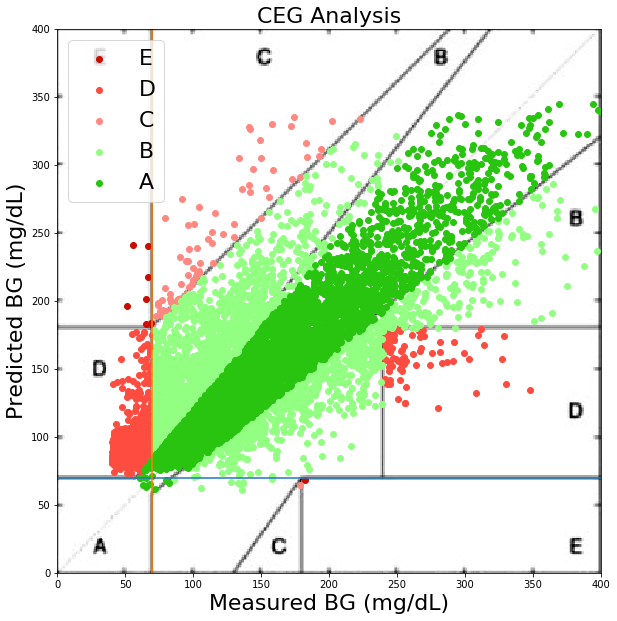

In [88]:
props = CEG_analysis(test_y,pd.Series(y_preds))
plt.plot([0,400],[70,70])
plt.plot([70,70],[0,400])

In [231]:
len(data_bypat['m4'].columns)
x_pca_train.shape

(94676, 18)

In [89]:
props[0]+props[1]

86.76626506024097

### Test the effective prediction time

In [165]:
train_y_c = (train_y<=70)*1
test_y_c = (test_y<=70)*1
np.sum(train_y_c)/len(train_y_c)


0.0615917821947553

In [231]:
p_effs = [] # holder for effective prediction horizons

outofbounds = 0
hyposep = 0
insuf_data = 0
hypos=0

leads_check = []

# get pca_transforms
feature_cols = set(train_x.columns)-set(["full_time"])
train_x_pca, test_x_pca, __ = PCA_transform(train_x[feature_cols],test_x[feature_cols]) # PCA transform data
train_x_pca = train_x_pca[:,:9]
test_x_pca = test_x_pca[:,:9]

## DO the WIEHGTH TESTING
weights = np.ones(np.shape(train_y)) + (train_y<=70)#*300



# model to use for testing p_eff 
forest = RandomForestRegressor(n_estimators=50, max_depth=15, max_features=9//3)
forest.fit(train_x_pca,train_y)
c_forest = RandomForestClassifier(n_estimators=50, max_depth=15, max_features=9//3)
c_forest.fit(train_x_pca, train_y_c, weights)


hypo_inds = np.squeeze(np.argwhere(train_y_c==1))
v_inds = np.squeeze(np.argwhere(test_y_c==1))
hp_score = c_forest.score(train_x_pca[hypo_inds], train_y_c[hypo_inds])
val_score = c_forest.score(test_x_pca[v_inds],test_y_c[v_inds])
print("hypo acc:", hp_score)
print("val:", val_score)

y_preds = forest.predict(test_x_pca)
hypo_preds = c_forest.predict(test_x_pca)

for index in test_x.index.values:
    # if the relevant entries dont exist, skip
    if  not ((index+1 in test_x.index.values) and (index-6 in test_x.index.values)): 
        outofbounds=outofbounds+1
        continue
     
    # if t0 and t0+1ind are not both hypo or t0-1 ind is hypo (i.e. t0 doesnt represents first time of hypo), skip
    if not (((test_x.iloc[index]["BG0"] <=70)  and (test_x.iloc[index+1]["BG0"] <=70)) and (test_x.iloc[index-1]["BG0"] >70)):
        continue
    
    hypos = hypos+1
        
        
    # if hypos are more than 10 minutes apart
    td_hypo = test_x_time.iloc[index+1]["full_time"]-test_x_time.iloc[index]["full_time"]
    td_hypo = np.round(td_hypo.seconds/60)
    if td_hypo > 10:
        hyposep = hyposep+1
        continue
        
    #  if you do not have a full thirty mins of prediction lead     
    td_lead = test_x_time.iloc[index]["full_time"]-test_x_time.iloc[index-6]["full_time"]
    td_lead = np.round(td_lead.seconds/60)  
    leads_check.append(td_lead)
    if not ((td_lead >29) and (td_lead <31)):
        insuf_data = insuf_data+1
        continue
        
        
    if (test_x.iloc[index]["BG0"] == test_y[index-6])==False:
        continue
    # test to see if hypoglycemia predicted at each of the 6 lead times (30 min, 25, 20 etc)
    print(test_y[index-6], ":", y_preds[index-6], ":",hypo_preds[index-6])
    for lead in [6,5,4,3,2,1]:
        # get predictors at t0-lead
        #lead_pred = forest.predict(test_x_pca[index-lead].reshape(1,-1))
        lead_pred = y_preds[index-lead]
     #   hypo_pred = hypo_preds[index-lead]
        hypo_pred = 0
        # if hypoglycemia predicted, append prediction horizon to p_effs

        if ((lead_pred <= 70) or (hypo_pred==1)):
            p_effs.append(lead*5)
            break
        if (lead==1):
            p_effs.append(0)
    
        
print("done")

    dtemp30     step0        t0  hr0adj_curr  hr0adj_mean_1hr   dtemp60  \
0 -0.508685  1.541715  1.293199    -0.131813        -0.149105 -0.617141   
1 -0.508685  0.051197  1.293199    -0.330841        -0.263074 -0.617141   
2 -0.508685 -0.291837  1.293199    -0.574810        -0.394198 -0.617141   
3 -0.508685 -0.191729  1.293199    -0.472856        -0.430570 -0.617141   
4 -0.508685  0.736868  1.293199    -0.164557        -0.381777 -0.617141   

   step0mean_2hr     temp0  hr0adj_mean_5hr      eda0  ...  hr0adj_mean_3hr  \
0       -0.34838 -0.123446         -0.08714  0.493738  ...        -0.092454   
1       -0.34838 -0.110782         -0.08714  0.772644  ...        -0.092454   
2       -0.34838 -0.091480         -0.08714  0.686337  ...        -0.092454   
3       -0.34838 -0.079479         -0.08714  0.830795  ...        -0.092454   
4       -0.34838 -0.060916         -0.08714  0.931636  ...        -0.092454   

   hr0adj_mean_2hr    deda60  step0mean_3hr       hr0  tempday_var    deda

C:\Users\coh275\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


hypo acc: 0.788135593220339
val: 0.3076923076923077
69.0 : 140.48379117099344 : 0
54.0 : 99.07669047619046 : 0
70.0 : 145.52026598558984 : 0
69.0 : 126.44378156130111 : 0
69.0 : 143.28713064210137 : 0
70.0 : 106.97654855172783 : 0
62.0 : 139.58856467288018 : 0
66.0 : 154.83399181234262 : 0
70.0 : 145.8053739473971 : 0
66.0 : 106.49120137766555 : 0
65.0 : 128.5942065694459 : 0
68.0 : 152.05719730868378 : 0
70.0 : 82.85614661155209 : 0
70.0 : 83.17969631445084 : 0
66.0 : 90.67918774932929 : 0
70.0 : 81.26116798243011 : 0
69.0 : 78.5482973518241 : 0
70.0 : 86.9171729527942 : 0
64.0 : 142.46053455651082 : 0
69.0 : 147.58011952725886 : 0
68.0 : 90.90074684995923 : 0
68.0 : 104.26443264400065 : 0
57.0 : 120.05053020768851 : 0
70.0 : 69.64063476882538 : 1
69.0 : 85.45265919502786 : 0
70.0 : 81.61812837474156 : 0
68.0 : 76.37812855602867 : 0
67.0 : 86.74449858789038 : 0
69.0 : 81.44161698185798 : 0
69.0 : 74.74077313342637 : 0
68.0 : 75.52105336689391 : 0
64.0 : 95.46317013918308 : 0
70.0 : 79

In [163]:
#td_test = test_x.iloc[4]['full_time']-test_x.iloc[3]["full_time"]
#td_test.seconds//60
train_y_c.shape

(95792,)

In [64]:
# model to use for testing p_eff 
#forest = RandomForestRegressor(n_estimators=50, max_depth=15, max_features=9//3)
#forest.fit(train_x_pca,train_y)

#y_preds = forest.predict(test_x_pca)

In [72]:
#np.sum(np.diff(test_x.index.values)==1)/(len(test_x.index.values)-1)

1.0

In [232]:
np.mean(p_effs)

3.2222222222222223

In [170]:
# PHcs = {}
# PHcs[0] = np.mean(p_effs)

In [228]:
PHcs[300] = np.mean(p_effs)

In [230]:
PHcs

{0: 1.0825237536030747,
 1: 1.4951425216184477,
 2: 1.6216504750720615,
 3: 1.7961994235080603,
 10: 15.222222222222221,
 100: 23.333333333333332,
 500: 27.11111111111111,
 200: 24.555555555555557,
 300: 25.77777777777778}

In [130]:
PHs

{0: 0.6037151702786377,
 1: 1.0841251201024875,
 2: 1.2640119568698622,
 3: 1.4748585459592185,
 5: 1.7188000427031067,
 5000: 10.512971068645244,
 10000: 10.869542009181169,
 100000: 10.103555033628696}

In [218]:
n_inds = np.squeeze(np.argwhere(test_y_c==0))
hypo_preds[n_inds]

array([0, 0, 0, ..., 0, 1, 0], dtype=int32)

In [229]:
n_inds = np.argwhere(test_y_c==0)
np.sum(hypo_preds[n_inds])/len(n_inds)

C:\Users\coh275\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


0.3138099339649727

In [87]:
weights = np.ones(np.shape(train_y)) + (train_y<=70)*1

In [131]:
weights.describe()

count     95792.000000
mean       6160.178219
std       24041.388882
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max      100001.000000
Name: BG_PH, dtype: float64

In [127]:
y_preds

array([202.61712394,  96.21197853,  86.99937368, ...,  68.10662462,
        72.99310082,  69.33170913])

## FINAL TRAINING FOR IMPLEMENTATION

In [140]:
np.concatenate((train_y,test_y),0).shape


(106618,)

In [142]:
# dont run more than once, ensure length is correct
#x_final = np.concatenate((train_x_pca,test_x_pca),0)
#y_final = np.concatenate((train_y,test_y),0)
print(x_final.shape)

(106618, 9)


In [144]:
forest_final = RandomForestRegressor(n_estimators=50, max_depth=15, max_features=9//3)
forest_final.fit(x_final,y_final)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [148]:
predf = forest_final.predict(x_final[200].reshape(1,-1))
print(predf,":",y_final[200])

[137.26094657] : 149.0


In [147]:
x_final[200].shape

(9,)

In [150]:
pickle.dump(forest_final,open("RF_model.p", "wb"))

In [151]:
loaded_model = pickle.load(open("RF_model.p","rb"))

In [152]:
predt = loaded_model.predict(x_final[200].reshape(1,-1))
print(predt,":",y_final[200])

[137.26094657] : 149.0
